# Movie Maker for TDMS files using FFmpeg

### Required packages:

- npTDMS (!pip install nptdms)
- FFmpeg (http://www.wikihow.com/Install-FFmpeg-on-Windows)

In [1]:
import numpy as np
import matplotlib
#matplotlib.use("agg")
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation # https://matplotlib.org/api/animation_api.html

import fnmatch
import sys, os

from IPython.display import clear_output

from nptdms import TdmsFile # this library contains the actual TDMS loading parts
#from ipywidgets import interact

from matplotlib import colors
import pickle
from scipy import ndimage

import pandas as pd
import trackpy as tp

In [2]:
fdir = 'E:/' # set the "Select Files..." dialog start directory to the notebook directory
def openFilesDialog(fdir):
    from PyQt5.QtWidgets import QApplication,QFileDialog
    app = QApplication([dir])
    files = QFileDialog.getOpenFileNames(None, "Select Files...", fdir, filter='TDMS Files (*.tdms);;All Files (*)')
    return files[0]

def loadTDMSImages(file):
    global exposure, dimx, dimy, binning
    tdms_file = TdmsFile(file)
    p=tdms_file.object().properties   
    dimx=int(p['dimx'])  
    dimy=int(p['dimy'])
    frames=int(p['dimz'])
    binning=int(p['binning'])
    exposure=float(p['exposure'])
    images=tdms_file.channel_data('Image','Image')
    return images.reshape(frames,dimx,dimy)

## Select files to process

In [3]:
files = openFilesDialog(fdir)
fdir = os.path.dirname(files[0]) # set the dialog start directory to the selected directory
print('Selected Files:')
for file in files:
    print(file)

Selected Files:
E:/180423_A-Beta_Fibril_ThT_Trapping/Set2/Set2_001_movie.tdms
E:/180423_A-Beta_Fibril_ThT_Trapping/Set2/Set2_002_movie.tdms
E:/180423_A-Beta_Fibril_ThT_Trapping/Set2/Set2_003_movie.tdms
E:/180423_A-Beta_Fibril_ThT_Trapping/Set2/Set2_004_movie.tdms
E:/180423_A-Beta_Fibril_ThT_Trapping/Set2/Set2_005_movie.tdms
E:/180423_A-Beta_Fibril_ThT_Trapping/Set2/Set2_006_movie.tdms
E:/180423_A-Beta_Fibril_ThT_Trapping/Set2/Set2_007_movie.tdms
E:/180423_A-Beta_Fibril_ThT_Trapping/Set2/Set2_008_movie.tdms
E:/180423_A-Beta_Fibril_ThT_Trapping/Set2/Set2_009_movie.tdms
E:/180423_A-Beta_Fibril_ThT_Trapping/Set2/Set2_010_movie.tdms
E:/180423_A-Beta_Fibril_ThT_Trapping/Set2/Set2_011_movie.tdms
E:/180423_A-Beta_Fibril_ThT_Trapping/Set2/Set2_012_movie.tdms


In [4]:
# Trajectory
#f = pd.read_pickle('E:/180227_A-Beta_Fibril_ThT_Trapping/Set4_006_features.pkl')
#t = tp.link_df(f, search_range=25, memory=3)
#df = tp.filter_stubs(t, 10)

##  Select color map

In [5]:
try:  
    cmap = pickle.load(open('colormaps/cmap_tht.pkl', 'rb'))
    #cmap = 'gray'
    #cmap = 'viridis'
except Exception as e:
    cmap = 'gray' # default
    print(e, 'Using the default color map.')

## Here, you can test color scale, overlay, ...

In [6]:
# find the first *_movie.tdms in the list of files and load it 
i = [i for i, file in enumerate(files) if fnmatch.fnmatch(file, '*_movie.tdms')][0]
#i = 0
images = loadTDMSImages(files[i])

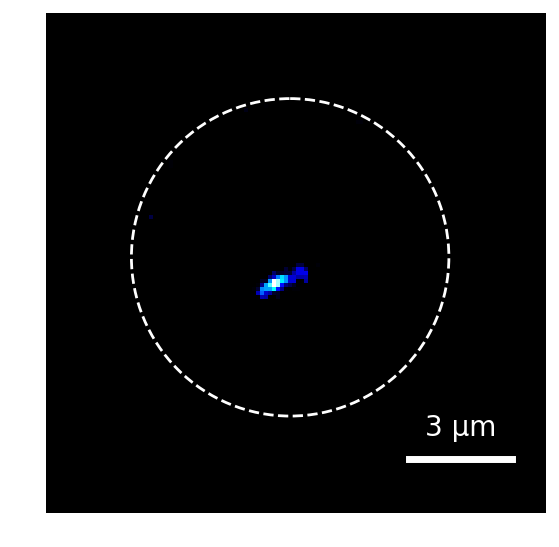

In [12]:
k = 0
image = images[k]

# color scale 
autoscale = False
vmin = 300
vmax = 900

subx = dimx  
suby = dimy

# overlay
scalebar = True
if scalebar:
    um2px = 0.0577*binning # µm/px
    sb_um = 3 # µm 
    sb_x = 0.825*(dimx+subx)/2
    sb_y = 0.825*(dimy+suby)/2
    sb_px = int(np.round(sb_um/um2px))

# filters
medianfilter = True
median = 2
if median:
    image = ndimage.median_filter(image, median) 

# mask
mask = True
if mask:
    x0 = 61; y0 = 61
    radius = 39
    xx, yy= np.meshgrid(np.arange(0, dimx, 1), np.arange(0, dimy, 1))
    maskimage = (((xx - x0)**2 + (yy - y0)**2) < (radius)**2).astype(int)
    image = image*maskimage

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(1,1,1)

if autoscale:
    ax.imshow(image, cmap=cmap)
else:
    ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
if scalebar:
    ax.text(sb_x, sb_y, str(sb_um) + ' µm', va='center',ha='center',color='w',fontsize=20)

#ax.set_xlim(x0-subx/2, x0+subx/2)
#ax.set_ylim(y0+suby/2, y0-suby/2)

if subx != dimx or suby != dimy:
    ax.set_xlim((dimx-subx)/2, (dimx+subx)/2)
    ax.set_ylim((dimy+suby)/2, (dimy-suby)/2)

#ax.text(425, 50, 'On', va='center',ha='left',color='w',fontsize=20)
ri = 40
ax.add_patch(plt.Circle((x0, y0), radius=ri, color='w', ls='--', lw=2, fill=False))
#ro = 50
#ax.add_patch(plt.Circle((x0, y0), radius=ro, color='w', ls='-', lw=2, fill=False))

ax.plot([sb_x-sb_px/2, sb_x+sb_px/2], [1.075*sb_y, 1.075*sb_y], 'w', lw=5);

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.axis('off')

# Trajectory
#ax.plot(f['x'].tolist()[0:k], f['y'].tolist()[0:k], 'w', alpha=0.25)

export = True
if export:
    plt.savefig(files[i].replace('_movie.tdms','.png'), dpi=300)

## Process files individually

E:/180424_A-Beta_Fibril_ThT_Trapping+Monomer/Set1_003_movie.tdms
Progress: 99 %


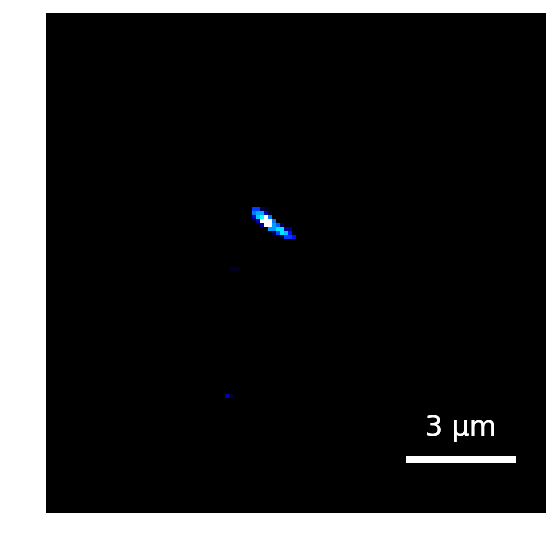

In [40]:
ffmpegWriter = animation.writers['ffmpeg']

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(1,1,1)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
#im = plt.imshow(images[0], cmap=cmap) # vmax=...
# scale bar
#plt.text(sb_x, sb_y, str(sb_um) + ' µm', va='center',ha='center',color='w',fontsize=20)
#plt.plot([sb_x-sb_px/2, sb_x+sb_px/2], [1.075*sb_y, 1.075*sb_y], 'w', lw=5)
plt.axis('off')
        
#images = np.zeros(0)        
for file in files:
    if fnmatch.fnmatch(file,'*_movie.tdms'): # load only the *_movie.tdms files of the selected files
        images = loadTDMSImages(file)
        if autoscale:
            im = plt.imshow(images[0], cmap=cmap)
        else:
            im = plt.imshow(images[0], cmap=cmap, vmin=vmin, vmax=vmax)
        # overlay
        if scalebar:
            ax.text(sb_x, sb_y, str(sb_um) + ' µm', va='center', ha='center', color='w', fontsize=20)
            ax.plot([sb_x-sb_px/2, sb_x+sb_px/2], [1.075*sb_y, 1.075*sb_y], 'w', lw=5)

        #ax.add_patch(plt.Circle((x0, y0), radius=r1, color='w', linewidth=1, fill=False))
        if images.shape[0] > 1: # check if there is more than one frame
            writer = ffmpegWriter(fps=1./exposure) # '.mp4'
            with writer.saving(fig, file.replace('_movie.tdms','') + ".mp4", dpi=100): # !!!
                for i in range(images.shape[0]):
                    image = images[i]
                    if medianfilter:
                        image = ndimage.median_filter(image, median)
                    if mask:
                        image = image*maskimage
                    im.set_data(image)
                    writer.grab_frame()
                    if (i % 10 == 0):
                        clear_output(wait=True)
                        print(file + '\n' + 'Progress:', int(i/images.shape[0]*100), '%')
        #else:   
            # save as '.png' 
            


## Concatenate files

In [29]:
images = np.array([])
for file in files:
    if fnmatch.fnmatch(file, '*_movie.tdms'): # load only the *_movie.tdms files of the selected files
        if images.size == 0:
            images = loadTDMSImages(file)
        else:
            images = np.concatenate((images, loadTDMSImages(file)), axis=0)
print(images.shape)

(5000, 251, 251)


Progress: 99 %


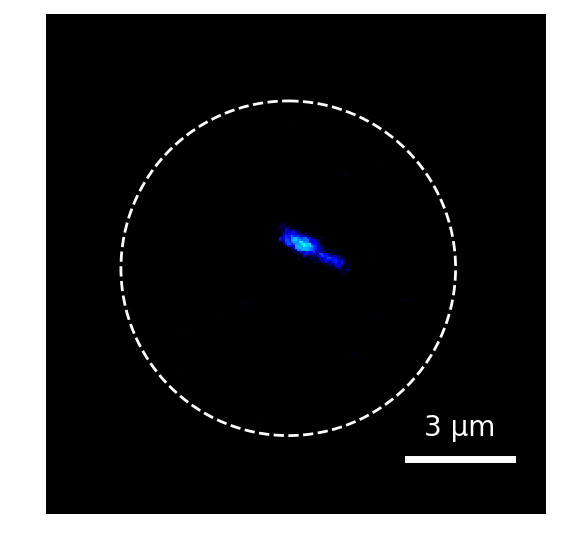

In [30]:
ffmpegWriter = animation.writers['ffmpeg']
#writer = ffmpegWriter(fps=1./exposure,codec="msvideo1") # + ".avi" for PowerPoint 2010
writer = ffmpegWriter(fps=1./exposure) # + ".mp4"

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(1,1,1)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
if autoscale:
    im = plt.imshow(images[0], cmap=cmap)
else:
    im = plt.imshow(images[0], cmap=cmap, vmin=vmin, vmax=vmax)
# overlay
if scalebar:
    ax.text(sb_x, sb_y, str(sb_um) + ' µm', va='center', ha='center', color='w', fontsize=20)
    ax.plot([sb_x-sb_px/2, sb_x+sb_px/2], [1.075*sb_y, 1.075*sb_y], 'w', lw=5)
ax.add_patch(plt.Circle((x0, y0), radius=ri, color='w', ls='--', lw=2, fill=False))

if subx != dimx or suby != dimy:
    ax.set_xlim((dimx-subx)/2, (dimx+subx)/2)
    ax.set_ylim((dimy+suby)/2, (dimy-suby)/2)
            
# trajectory
#l, = plt.plot([], [], 'w-', lw=1)
plt.axis('off')

with writer.saving(fig, files[0].replace('_001_movie.tdms','') + ".mp4", dpi=100):
    for i in range(images.shape[0]):
        image = images[i]
        if medianfilter:
            image = ndimage.median_filter(image, median)
        if mask:
            image = image*maskimage
        im.set_data(image)
        # Text
        #if (i == 100):
        #    txt.set_text('On');
        # Trajectory
        #spots=pd.read_pickle(files[0].replace('_001_movie.tdms','') + '_spots.pkl')
        #l.set_data(spots[:i].x, spots[:i].y)
        writer.grab_frame()
        if (i % 10 == 0):
            clear_output(wait=True)
            print('Progress:', int(i/images.shape[0]*100), '%')